# Superstore Marketing Campaign Dataset
Dataset from: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

Context - A superstore is planning for the year-end sale. They want to launch a new offer - gold membership, that gives a 20% discount on all purchases, for only \$499 which is \$999 on other days. It will be valid only for existing customers and the campaign through phone calls is currently being planned for them. The management feels that the best way to reduce the cost of the campaign is to make a predictive model which will classify customers who might purchase the offer.

Objective - The superstore wants to predict the likelihood of the customer giving a positive response and wants to identify the different factors which affect the customer's response. You need to analyze the data provided to identify these factors and then build a prediction model to predict the probability of a customer will give a positive response.

**Additional Objective**: Choose AUC score as the target metric, but account for precision and recall as secondary metrics.

# Executive Summary
- A prediction model can be effective in reducing costs for the company, but it depends on how much each customer costs to convert.
- Best and worst customer profiles have been created to help with targeting potential new members.
- Additional features importances provide higher correlated features in customers to target.

# EDA

#### Preview Dataset

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('data/superstore.csv', parse_dates=['Dt_Customer'], index_col='Dt_Customer')

# Display the first few rows of the dataset
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
Dt_Customer,,,,,,,,,,,,,,,,,,,,,
2014-06-16,1826,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0
2014-06-15,1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2014-05-13,10476,1958,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0
2014-11-05,1386,1967,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0
2014-08-04,5371,1989,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0


In [2]:
# Create a new column 'TotalSpent' by summing all columns that start with 'Mnt'
data['TotalSpent'] = data[[col for col in data.columns if col.startswith('Mnt')]].sum(axis=1)

# Display the first few rows with the new column
data[['TotalSpent']].head()

,TotalSpent
Dt_Customer,
2014-06-16,1190
2014-06-15,577
2014-05-13,251
2014-11-05,11
2014-08-04,91


## Visualize dataset over time (`Dt_Customer`)

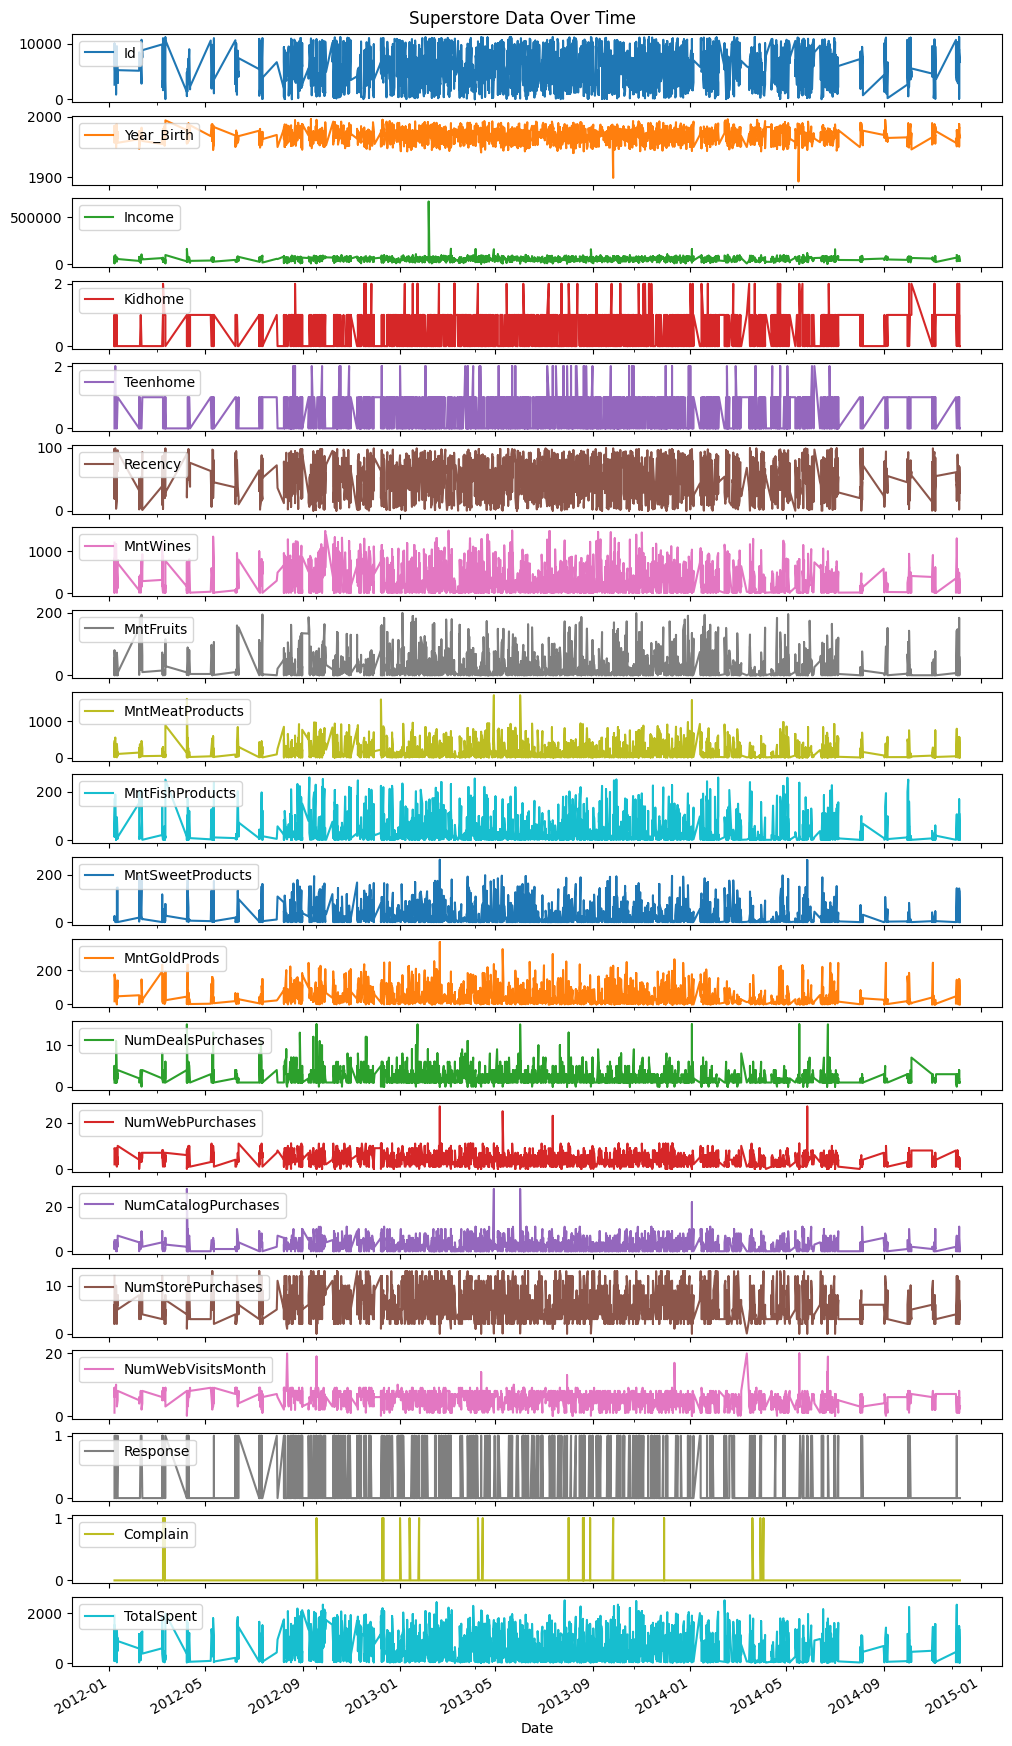

In [3]:
import matplotlib.pyplot as plt

# Plot data over time
ax = data.plot(subplots=True, figsize=(12, 24))

# Set title below the graph
plt.suptitle('Superstore Data Over Time', y=0.89)

# Move legends to upper left corners
for a in ax:
    a.legend(loc='upper left')

# Set x-axis label
for a in ax:
    a.set_xlabel('Date')

plt.show()

#### Check for missing values

In [4]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Display columns with missing values (if any)
missing_values[missing_values > 0]

Income    24
dtype: int64

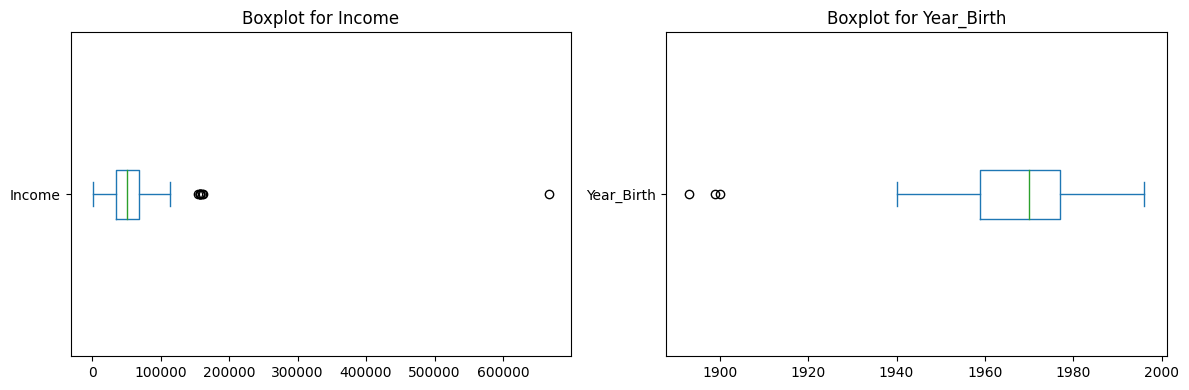

In [5]:
# Plot boxplots for 'Income' and 'Year_Birth' to visualize outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot for 'Income'
data['Income'].plot(kind='box', ax=ax[0], vert=False)
ax[0].set_title('Boxplot for Income')

# Boxplot for 'Year_Birth'
data['Year_Birth'].plot(kind='box', ax=ax[1], vert=False)
ax[1].set_title('Boxplot for Year_Birth')

plt.tight_layout()
plt.show()

### What are the extreme outliers?

In [6]:
# Define a function to compute the IQR and identify extreme outliers
def find_outliers(ser):
    Q1 = ser.quantile(0.25)
    Q3 = ser.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.0 * IQR
    upper_bound = Q3 + 3.0 * IQR
    
    return ser[(ser < lower_bound) | (ser > upper_bound)]

# Find outliers for 'Income' and 'Year_Birth'
income_outliers = find_outliers(data['Income'])
year_birth_outliers = find_outliers(data['Year_Birth'])

print(f'{income_outliers}'
      f'\n\n{year_birth_outliers}')

Dt_Customer
2013-02-06    666666.0
Name: Income, dtype: float64

Dt_Customer
2014-05-17    1893
2013-09-26    1899
2013-09-26    1900
Name: Year_Birth, dtype: int64


### `Income` Outliers

In [7]:
# Print out the entire row for income_outliers
income_outliers_rows = data[data['Income'].isin(income_outliers)]
income_outliers_rows

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalSpent
Dt_Customer,,,,,,,,,,,,,,,,,,,,,,
2013-02-06,9432,1977,Graduation,Together,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,0,0,62


### `year_birth` Outliers

In [8]:
# Print out the entire row for year_birth_outliers
year_birth_outliers_rows = data[data['Year_Birth'].isin(year_birth_outliers)]
year_birth_outliers_rows

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalSpent
Dt_Customer,,,,,,,,,,,,,,,,,,,,,,
2014-05-17,11004,1893,2n Cycle,Single,60182.0,0,1,23,8,0,5,7,0,2,1,1,0,2,4,0,0,22
2013-09-26,1150,1899,PhD,Together,83532.0,0,0,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1853
2013-09-26,7829,1900,2n Cycle,Divorced,36640.0,1,0,99,15,6,8,7,4,25,1,2,1,2,5,0,1,65


#### Remove outliers because response is 0 anyway.
It would be difficult to impute the age, and as dataset is imbalanced, let's remove the outliers.

In [9]:
# Removing outliers for 'Income' and 'Year_Birth'
data_cleaned = data.drop(income_outliers.index).drop(year_birth_outliers.index)

### Let's deal with categorical variables: `Education` and `Marital_Status`.

Combine into 4 groups for `Education` and 2 groups for `Marital_Status`.

In [10]:
# Grouping and renaming categories for 'Education'
data_cleaned['Education'] = data_cleaned['Education'].replace({
    '2n Cycle': 'Master',
    'Graduation': 'Bachelor',
    'Basic': 'High School'
})

# Grouping categories for 'Marital_Status'
data_cleaned['Marital_Status'] = data_cleaned['Marital_Status'].replace({
    'Widow': 'Single',
    'YOLO': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'Divorced': 'Single',
    'Together': 'Married'
})

# Extract the updated unique categories for 'Education' and 'Marital_Status'
updated_education_categories = data_cleaned['Education'].unique()
updated_marital_status_categories = data_cleaned['Marital_Status'].unique()

print(f'{updated_education_categories}'
      f'\n{updated_marital_status_categories}')

['Bachelor' 'PhD' 'Master' 'High School']
['Single' 'Married']


### How does our data look after removing outliers?

It looks better without the outliers, but the data is still more clustered between Aug/Sep 2012 and Jul/Aug 2014.

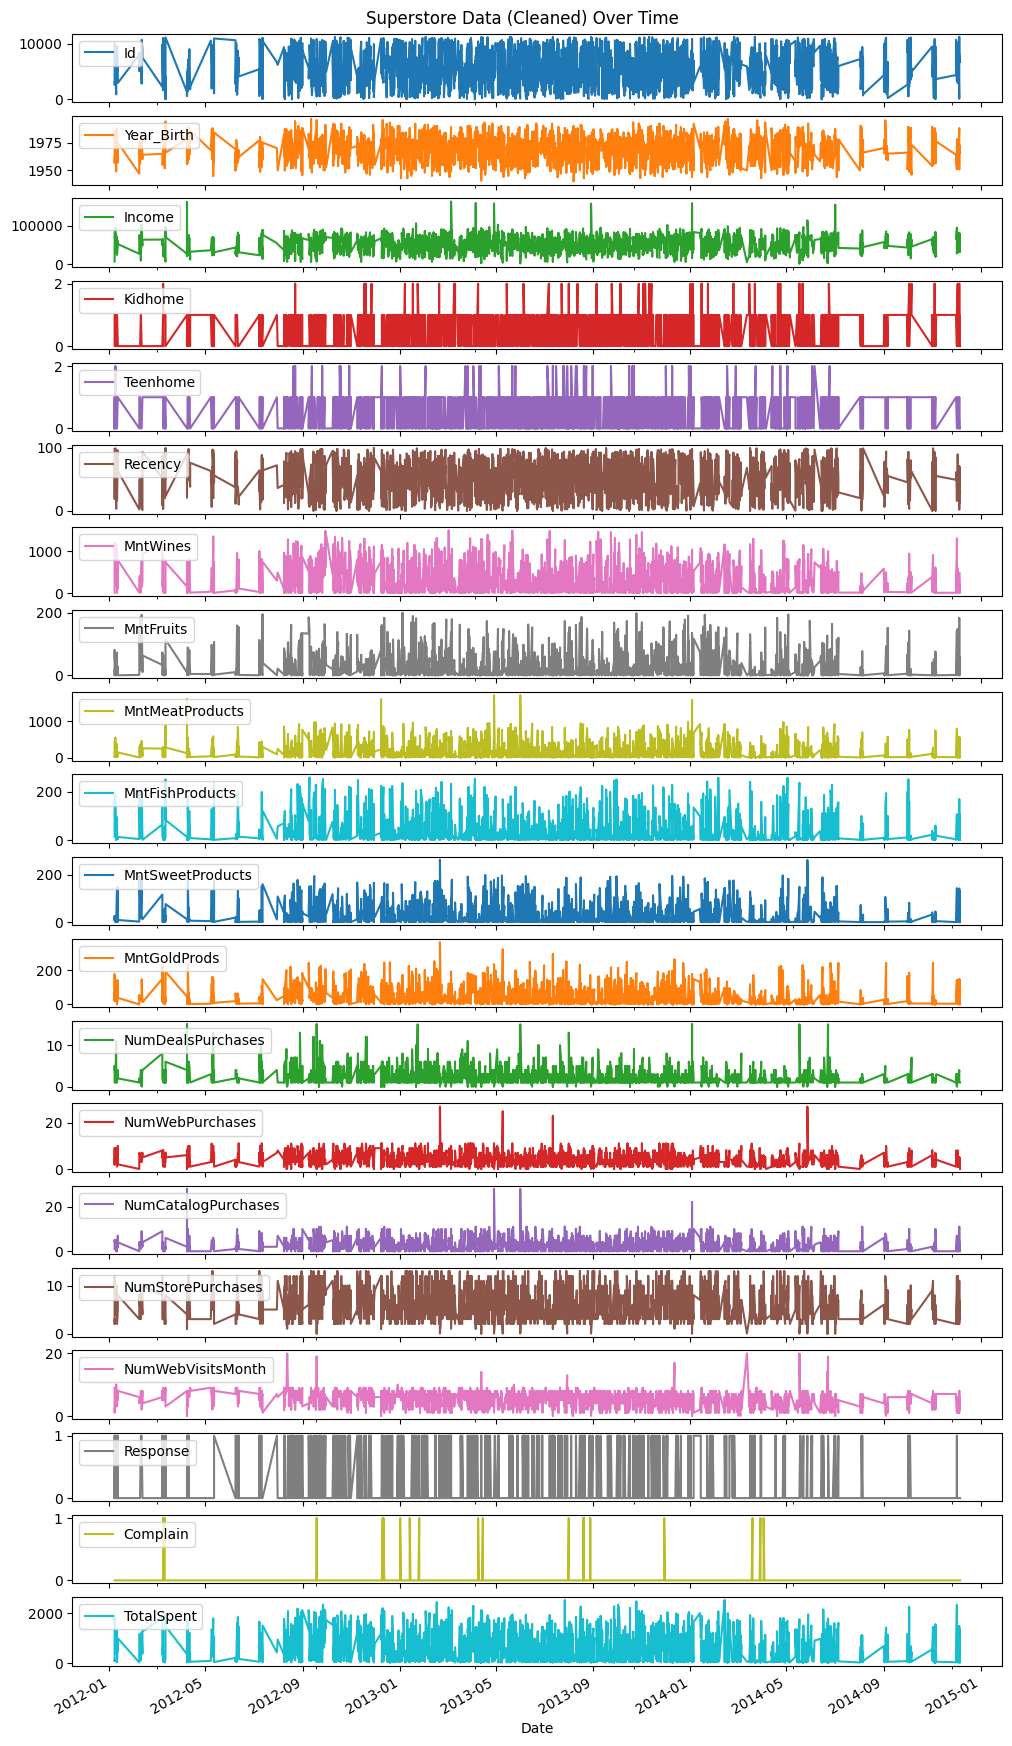

In [11]:
# Plot data over time
ax = data_cleaned.plot(subplots=True, figsize=(12, 24))

# Set title below the graph
plt.suptitle('Superstore Data (Cleaned) Over Time', y=0.89)

# Move legends to upper left corners
for a in ax:
    a.legend(loc='upper left')

# Set x-axis label
for a in ax:
    a.set_xlabel('Date')

plt.show()

### Extract year, month, day of month, and day of week from `Dt_Customer` and create as separate features.

`year`, `month`, `day`, and `weekday` respectively.

In [12]:
# Extract year, month, day of the month, and day of the week from 'Dt_Customer'
data_cleaned['Year'] = data_cleaned.index.year
data_cleaned['Month'] = data_cleaned.index.month
data_cleaned['Day'] = data_cleaned.index.day
data_cleaned['Weekday'] = data_cleaned.index.dayofweek  # 0 = Monday, 1 = Tuesday, ...

# Display the first few rows with the new columns
data_cleaned[['Year', 'Month', 'Day', 'Weekday']].head()

,Year,Month,Day,Weekday
Dt_Customer,,,,
2014-06-16,2014,6,16,0
2014-06-15,2014,6,15,6
2014-05-13,2014,5,13,1
2014-11-05,2014,11,5,2
2014-08-04,2014,8,4,0


### Distribution of `Response`

In [13]:
# Imbalance of 'Response'
data_cleaned['Response'].value_counts(normalize=True)

0    0.850425
1    0.149575
Name: Response, dtype: float64

### Correlation Heatmap

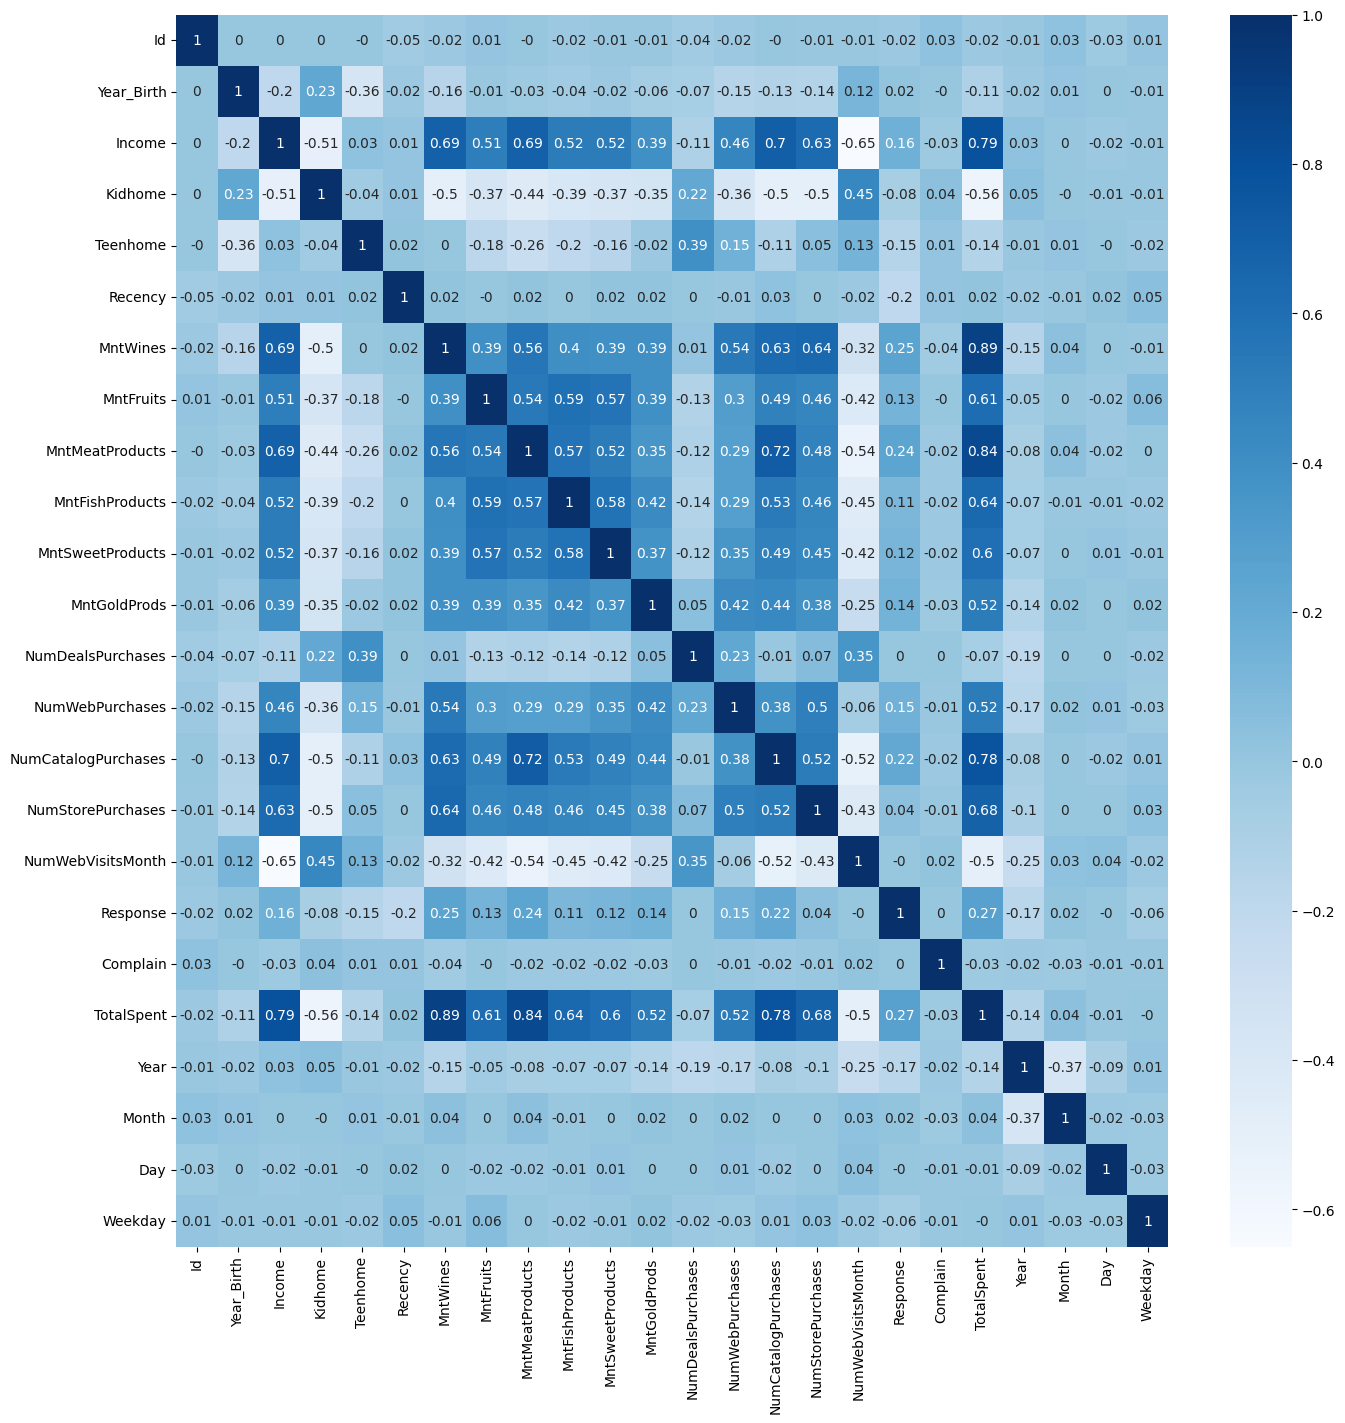

In [14]:
import numpy as np
import seaborn as sns

plt.figure(figsize=(16,16))
sns.heatmap(np.round(data_cleaned.corr(),2), annot=True, cmap='Blues')
plt.show()

Let's drop `TotalSpent` because of multicollinearity, as we do have the individual amounts spent. Let's also drop `year` as it is only a 3 year period, but we'll keep the other date features.

# Model Building

Let's split our dataset into train and test sets before imputing missing values to prevent data leakage.

In [15]:
from sklearn.model_selection import train_test_split

# Drop columns
X = data_cleaned.drop(columns=['Id', 'Response', 'TotalSpent', 'Year'])
y = data_cleaned['Response']

# Split the data into training and testing sets with a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train.shape, X_test.shape

((1563, 22), (670, 22))

## Imputed Missing Values for `Income`

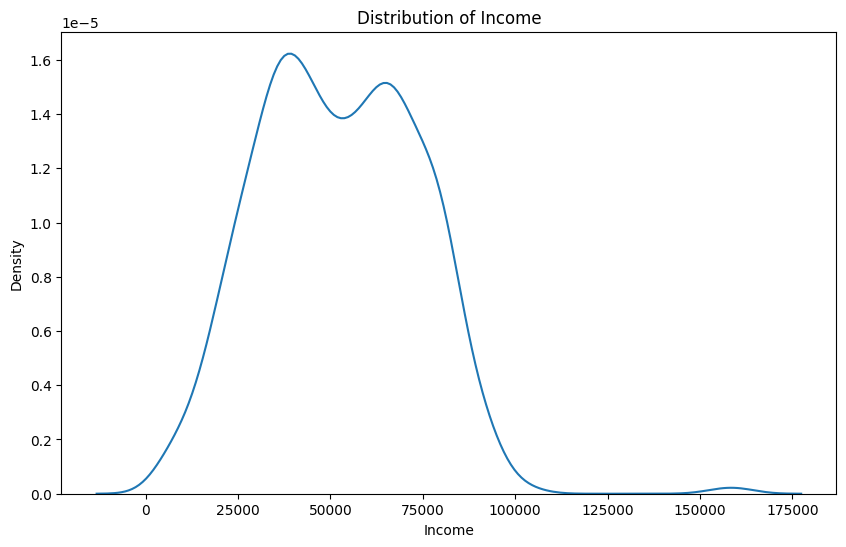

In [16]:
# Check distribution

plt.figure(figsize=(10, 6))
sns.kdeplot(X_train['Income'])
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Distribution of Income')
plt.show()

Let's impute with the median as there is a right skew for income.

In [17]:
from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='median')

# Impute missing values in 'Income' column for X_train
X_train['Income'] = imputer.fit_transform(X_train[['Income']])

# Impute missing values in 'Income' column for X_test
X_test['Income'] = imputer.transform(X_test[['Income']])

## One Hot Encoding of Categorical Variables

Education and Marital Status are our categorical variables to one-hot encode.

In [18]:
# One-hot encode the categorical variables
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensure that the training and testing data have the same columns after encoding
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, axis=1, fill_value=0)

## Start with the basics: Logistic Regression!

In [19]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data, cmap='Blues'):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(cmap=cmap)
    plt.show()

Accuracy: 0.8582
AUC: 0.8054

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       570
           1       0.60      0.15      0.24       100

    accuracy                           0.86       670
   macro avg       0.73      0.57      0.58       670
weighted avg       0.83      0.86      0.82       670



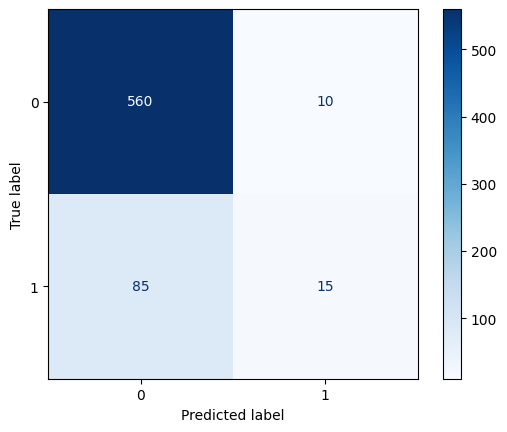

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, \
                            confusion_matrix, ConfusionMatrixDisplay

logreg_clf = LogisticRegression(random_state=42)
logreg_clf.fit(X_train_encoded, y_train)

logreg_predictions = logreg_clf.predict(X_test_encoded)
logreg_probs = logreg_clf.predict_proba(X_test_encoded)[:, 1]

logreg_acc = accuracy_score(y_test, logreg_predictions)
logreg_auc = roc_auc_score(y_test, logreg_probs)

logreg_clf_report = classification_report(y_test, logreg_predictions)

print(f'Accuracy: {logreg_acc:.4f}'
      f'\nAUC: {logreg_auc:.4f}'
      f'\n\n{logreg_clf_report}')

# Display Confusion Matrix
conf_matrix_plot(logreg_clf, X_test_encoded, y_test)

### Try a bit of tuning

In [21]:
from sklearn.model_selection import GridSearchCV

logreg_param_grid = {
    'C': [1], #[0.1, 1, 10],
    'penalty': ['l2'], #['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg'] #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

logreg_grid_search = GridSearchCV(estimator=logreg_clf, param_grid=logreg_param_grid, 
                                  scoring='roc_auc', cv=5, n_jobs=-1)

# Fit the grid search to the data
logreg_grid_search.fit(X_train_encoded, y_train)

# Best parameters from the grid search
logreg_best_params = logreg_grid_search.best_params_

logreg_best_params

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Accuracy: 0.8791
AUC: 0.8675

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       570
           1       0.65      0.41      0.50       100

    accuracy                           0.88       670
   macro avg       0.78      0.69      0.72       670
weighted avg       0.87      0.88      0.87       670



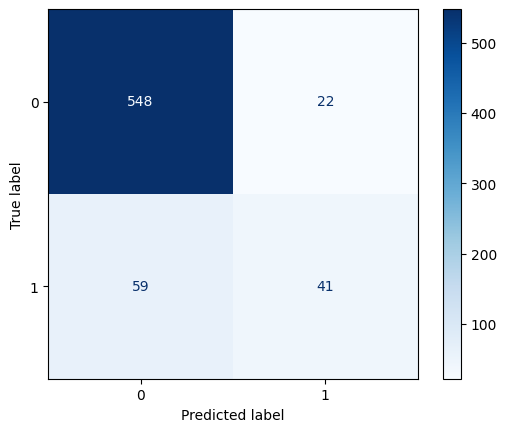

In [22]:
best_logreg_clf = LogisticRegression(
    C=1,
    penalty='l2',
    solver='newton-cg'
)

best_logreg_clf.fit(X_train_encoded, y_train)

# Predict on the test set
best_logreg_predictions = best_logreg_clf.predict(X_test_encoded)
best_logreg_probs = best_logreg_clf.predict_proba(X_test_encoded)[:,1]

# Calculate accuracy and AUC score
best_logreg_acc = accuracy_score(y_test, best_logreg_predictions)
best_logreg_auc = roc_auc_score(y_test, best_logreg_probs)

# Classification report
best_logreg_clf_report = classification_report(y_test, best_logreg_predictions)

print(f'Accuracy: {best_logreg_acc:.4f}'
      f'\nAUC: {best_logreg_auc:.4f}'
      f'\n\n{best_logreg_clf_report}')

# Display Confusion Matrix
conf_matrix_plot(best_logreg_clf, X_test_encoded, y_test)

### Not bad!
It's quite balanced with an F1-score of 0.5. Let's take a look at our feature importances.

For logistic regression, feature importances refer to the size of the coefficients, which can be positive or negative.

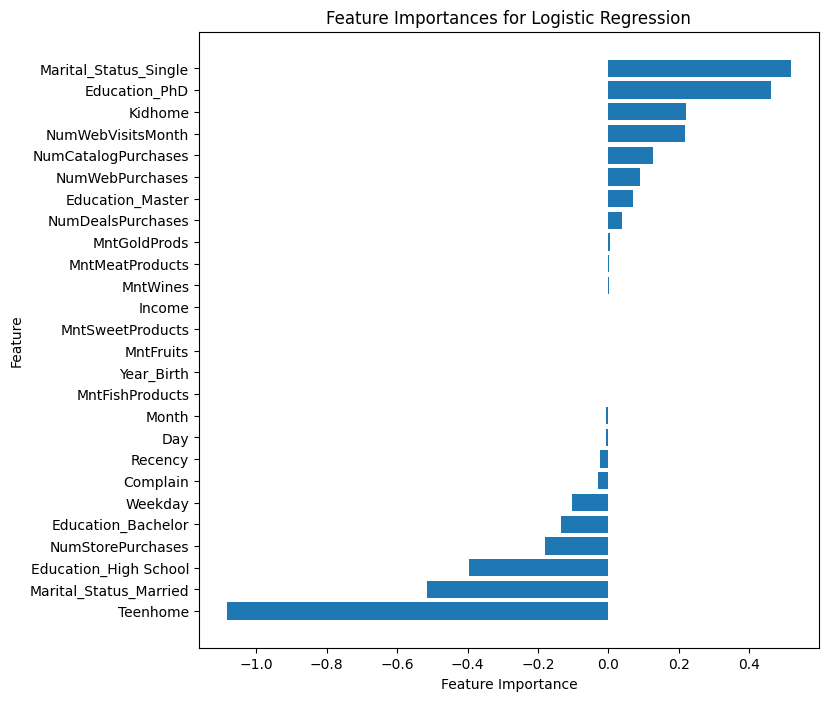

In [23]:
logreg_feature_importances = best_logreg_clf.coef_[0]

logreg_features_list = X_test_encoded.columns
logreg_feature_importance_pairs = list(zip(logreg_features_list, logreg_feature_importances))

logreg_sorted_feature_importance = sorted(logreg_feature_importance_pairs, key=lambda x: x[1], reverse=True)

logreg_features, logreg_importances = zip(*logreg_sorted_feature_importance)

plt.figure(figsize=(8, 8))
plt.barh(logreg_features, logreg_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

`Marital_Status` appears to play a strong role, although in different directions in being single vs. married. `Teenhome` appears to be the strongest but in a negative way (i.e. don't target people with teens).

## Try a Random Forest Classifier

Accuracy: 0.8806
AUC: 0.8770

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       570
           1       0.73      0.32      0.44       100

    accuracy                           0.88       670
   macro avg       0.81      0.65      0.69       670
weighted avg       0.87      0.88      0.86       670



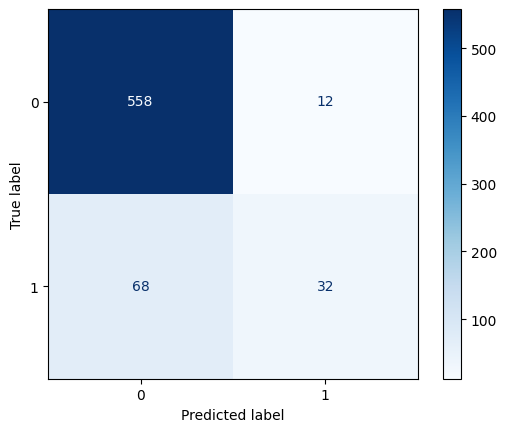

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_encoded, y_train)

rf_predictions = rf_clf.predict(X_test_encoded)
rf_probs = rf_clf.predict_proba(X_test_encoded)[:,1]

# Calculate accuracy and AUC score
rf_acc = accuracy_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_probs)

# Classification report
rf_clf_report = classification_report(y_test, rf_predictions)

print(f'Accuracy: {rf_acc:.4f}'
      f'\nAUC: {rf_auc:.4f}'
      f'\n\n{rf_clf_report}')

# Display Confusion Matrix
conf_matrix_plot(rf_clf, X_test_encoded, y_test)

### Not great overall. Recall is quite low, meaning that we are not capturing many responses.

Let's try hyperparameter tuning the model...

In [25]:
rf_param_grid = {
    'n_estimators': [500],                       # Number of trees in the forest
    'max_depth': [10], #[3, 5, 10],              # Maximum depth of the tree
    'min_samples_split': [2], #[2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2], #[1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True], #[True, False],         # Whether bootstrap samples are used when building trees
    'max_features': ['auto'] #['auto', 'sqrt']   # Number of features to consider when looking for best split
}

# Use GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, 
                              scoring='roc_auc', cv=3, n_jobs=-1)

# Fit the grid search to the data
rf_grid_search.fit(X_train_encoded, y_train)

# Best parameters from the grid search
rf_best_params = rf_grid_search.best_params_

rf_best_params

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

Accuracy: 0.8806
AUC: 0.8872

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       570
           1       0.79      0.27      0.40       100

    accuracy                           0.88       670
   macro avg       0.84      0.63      0.67       670
weighted avg       0.87      0.88      0.85       670



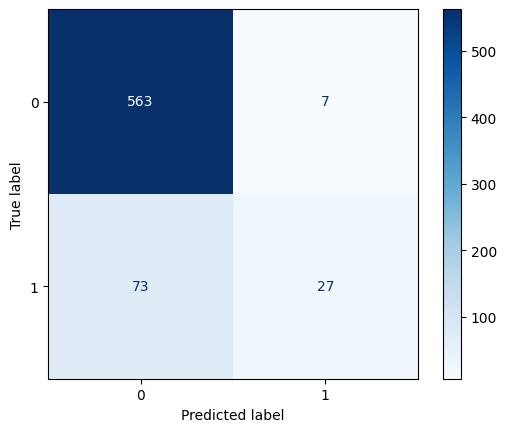

In [26]:
# Train the Random Forest classifier with the best hyperparameters
best_rf_clf = RandomForestClassifier(
    bootstrap=True,
    max_depth=10,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=500,
    random_state=42
)

best_rf_clf.fit(X_train_encoded, y_train)

# Predict on the test set
best_rf_predictions = best_rf_clf.predict(X_test_encoded)
best_rf_probs = best_rf_clf.predict_proba(X_test_encoded)[:,1]

# Calculate accuracy and AUC score
best_rf_acc = accuracy_score(y_test, best_rf_predictions)
best_rf_auc = roc_auc_score(y_test, best_rf_probs)

# Classification report
best_rf_clf_report = classification_report(y_test, best_rf_predictions)

print(f'Accuracy: {best_rf_acc:.4f}'
      f'\nAUC: {best_rf_auc:.4f}'
      f'\n\n{best_rf_clf_report}')

# Display Confusion Matrix
conf_matrix_plot(best_rf_clf, X_test_encoded, y_test)

### We made it worse!

Oops. AUC score went up, but everything else went down, which is a bit conflicting as our goal was to maximimze AUC score.

Let's look at feature importances. For tree based models, feature importances are always positive and should sum up to 1.

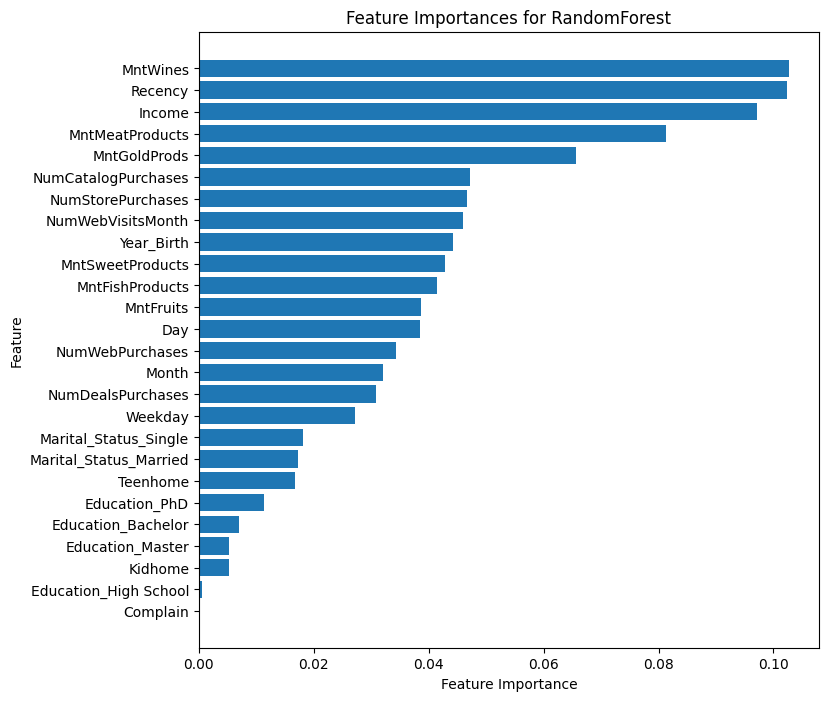

In [27]:
rf_feature_importances = best_rf_clf.feature_importances_

rf_features_list = X_test_encoded.columns
rf_feature_importance_pairs = list(zip(rf_features_list, rf_feature_importances))

rf_sorted_feature_importance = sorted(rf_feature_importance_pairs, key=lambda x: x[1], reverse=True)

rf_features, rf_importances = zip(*rf_sorted_feature_importance)

plt.figure(figsize=(8, 8))
plt.barh(rf_features, rf_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for RandomForest')
plt.gca().invert_yaxis()
plt.show()

It appears that the amount of wine, meat products, and gold products are important, in addition to recency of purchase, and income levels. This is quite different from our logistic regression model.

## Try SVM

Accouracy: 0.8507
AUC: 0.8504

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       570
           1       0.00      0.00      0.00       100

    accuracy                           0.85       670
   macro avg       0.43      0.50      0.46       670
weighted avg       0.72      0.85      0.78       670



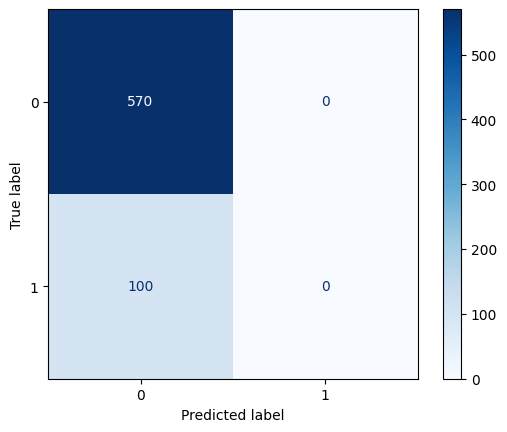

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Initialize and train an SVM classifier with a linear kernel
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)

# Predict on the test set
svm_predictions = svm_clf.predict(X_test_scaled)
svm_probs = svm_clf.predict_proba(X_test_scaled)[:,1]

# Calculate accuracy and AUC score
svm_acc = accuracy_score(y_test, svm_predictions)
svm_auc = roc_auc_score(y_test, svm_probs)

# Classification report
svm_report = classification_report(y_test, svm_predictions)

print(f'Accouracy: {svm_acc:.4f}'
      f'\nAUC: {svm_auc:.4f}'
      f'\n\n{svm_report}')

# Display Confusion Matrix
conf_matrix_plot(svm_clf, X_test_scaled, y_test)

### The model failed to capture any responses and predicted nobody accepting the offer.

Obviously, this model would be devastating for a marketing campaign. Let's try tuning.

#### Tune SVM

In [29]:
svm_param_grid = {
    'kernel': ['linear'],
    'C': [50], #[1, 10, 50, 100],
    'gamma': ['scale'], #['scale', 'auto', 0.1],
    'degree': [2], #[2, 3, 4],
    'class_weight': ['balanced'] #[None, 'balanced']
}

# Initialize GridSearchCV
svm_grid_search = GridSearchCV(svm_clf,
                               svm_param_grid,
                               scoring='roc_auc',
                               cv=3,
                               verbose=2,
                               n_jobs=-1)

# Perform the grid search
svm_grid_search.fit(X_train_scaled, y_train)

# Best parameters from the grid search
svm_best_params = svm_grid_search.best_params_

svm_best_params

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'C': 50,
 'class_weight': 'balanced',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'linear'}

Accuracy: 0.7552
AUC: 0.8727

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       570
           1       0.36      0.84      0.51       100

    accuracy                           0.76       670
   macro avg       0.66      0.79      0.67       670
weighted avg       0.87      0.76      0.79       670



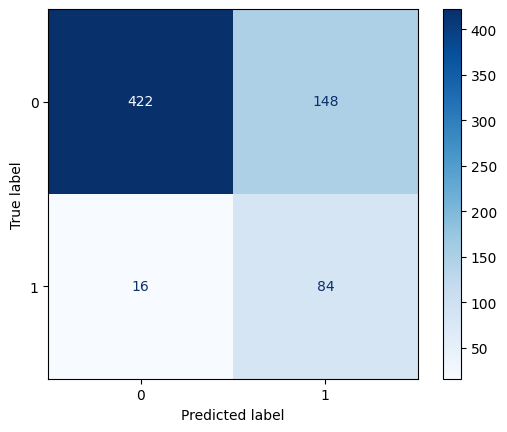

In [30]:
# Train the SVM classifier with the provided best hyperparameters
svm_best_clf = SVC(
    C=50,
    class_weight='balanced',
    degree=2,
    gamma='scale',
    kernel='linear',
    probability=True,
    random_state=42
)

svm_best_clf.fit(X_train_scaled, y_train)

# Predict on the test set
svm_best_predictions = svm_best_clf.predict(X_test_scaled)
svm_best_probs = svm_best_clf.predict_proba(X_test_scaled)[:,1]

# Calculate accuracy and AUC score
svm_best_acc = accuracy_score(y_test, svm_best_predictions)
svm_best_auc = roc_auc_score(y_test, svm_best_probs)

# Classification report
svm_best_report = classification_report(y_test, svm_best_predictions)

print(f'Accuracy: {svm_best_acc:.4f}'
      f'\nAUC: {svm_best_auc:.4f}'
      f'\n\n{svm_best_report}')

# Display Confusion Matrix
conf_matrix_plot(svm_best_clf, X_test_scaled, y_test)

### Much greater improvement!

However, the model is misclassifying by predicting that someone will accept, when they actually would not (i.e false positive).

Let's determine the most important features according to our SVM classifier model. Like logistic regression, linear SVM looks at coefficients for feature importances.

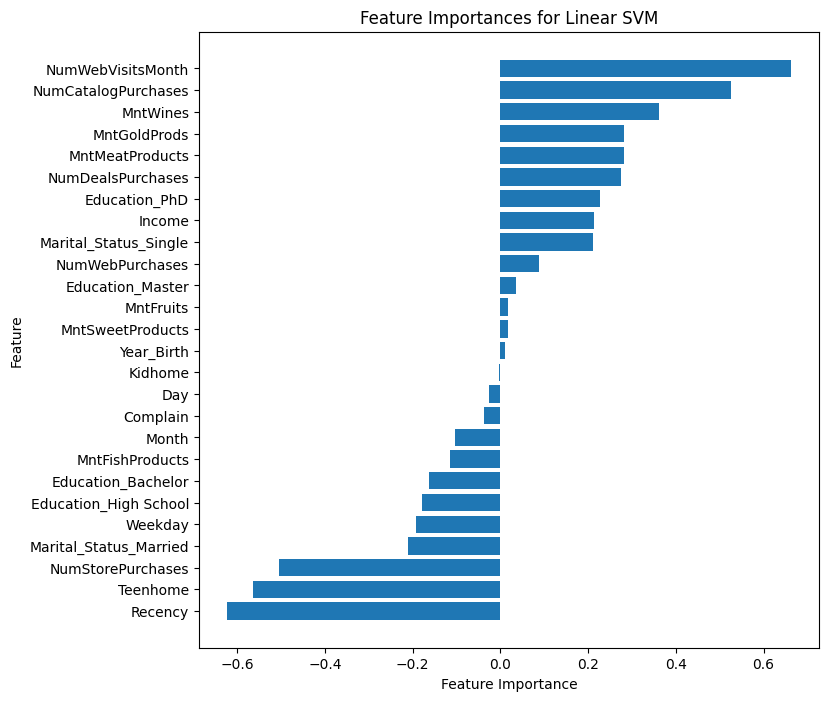

In [31]:
# For linear SVM, the coefficients represent the feature importances
svm_feature_importances = svm_best_clf.coef_[0]

# Pairing features with their importance scores
svm_features_list = X_test_encoded.columns
svm_feature_importance_pairs = list(zip(svm_features_list, svm_feature_importances))

# Sorting features based on importance
svm_sorted_feature_importance = sorted(svm_feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Extracting feature names and their importances
svm_features, svm_importances = zip(*svm_sorted_feature_importance)

# Plotting feature importances
plt.figure(figsize=(8, 8))
plt.barh(svm_features, svm_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Linear SVM')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

It would be expected for different feature importances for SVM compared to logistic regression because SVM has higher recall score (more False Positives), while logistic regression has higher precision score (more False Negatives).

`NumWebVisitsMonth` makes a first appearance, but `Recency` and `Teenhome` seem to be recurring features across a few models.

## Let's Try a Boosting Model

XGBoost!

In [32]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, seed=42)

# Let's just tune it
xgb_param_grid = {
    'learning_rate': [0.01], #[0.01, 0.05, 0.1],
    'max_depth': [3], #[3, 5, 7],
    'colsample_bytree': [0.5], #[0.3, 0.5, 0.7, 0.9],
    'gamma': [0.2] #[0.0, 0.1, 0.2]
}

xgb_grid_search = GridSearchCV(xgb_clf,
                               xgb_param_grid,
                               scoring='roc_auc',
                               cv=3,
                               verbose=2,
                               n_jobs=-1)

# Perform the grid search
xgb_grid_search.fit(X_train_encoded, y_train)

# Best parameters from the grid search
xgb_best_params = xgb_grid_search.best_params_

xgb_best_params

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3}

Accuracy: 0.8866
AUC: 0.8917

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       570
           1       0.72      0.39      0.51       100

    accuracy                           0.89       670
   macro avg       0.81      0.68      0.72       670
weighted avg       0.87      0.89      0.87       670



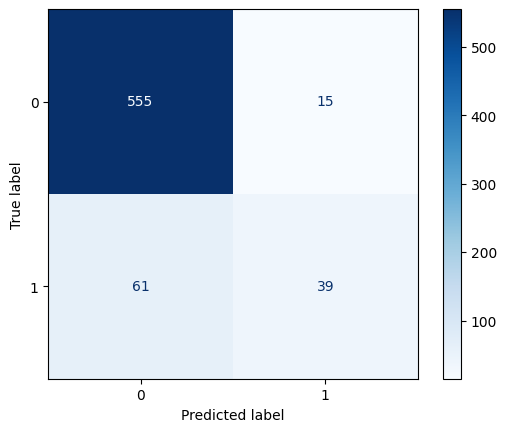

In [33]:
best_xgb_clf = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    colsample_bytree=0.5,
    gamma=0.2,
    n_estimators=1000,
    seed=42
)

best_xgb_clf.fit(X_train_encoded, y_train)

# Predict on the test set
best_xgb_predictions = best_xgb_clf.predict(X_test_encoded)
best_xgb_probs = best_xgb_clf.predict_proba(X_test_encoded)[:,1]

# Calculate accuracy and AUC score
best_xgb_acc = accuracy_score(y_test, best_xgb_predictions)
best_xgb_auc = roc_auc_score(y_test, best_xgb_probs)

# Classification report
best_xgb_report = classification_report(y_test, best_xgb_predictions)

print(f'Accuracy: {best_xgb_acc:.4f}'
      f'\nAUC: {best_xgb_auc:.4f}'
      f'\n\n{best_xgb_report}')

# Display Confusion Matrix
conf_matrix_plot(best_xgb_clf, X_test_encoded, y_test)

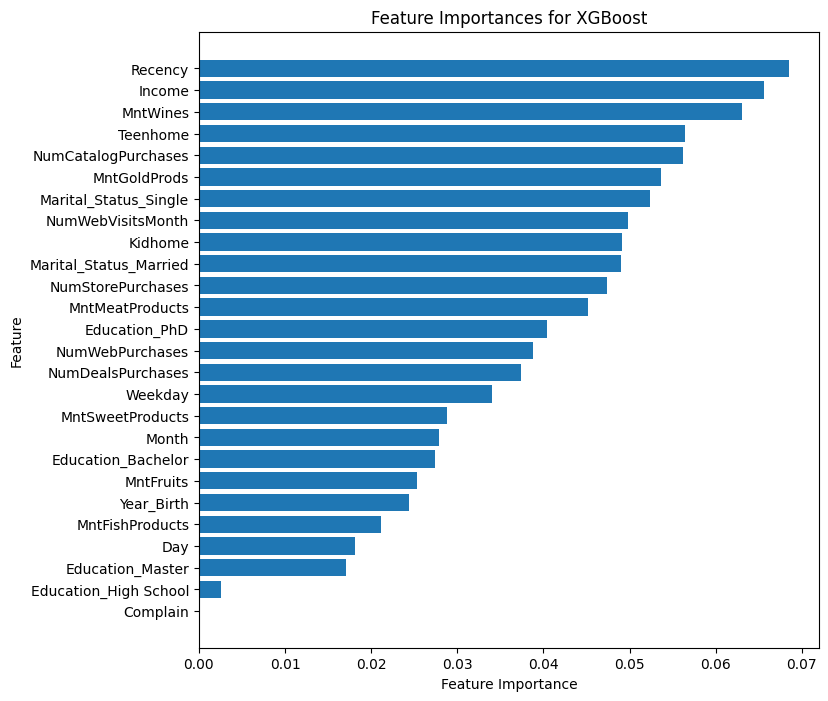

In [34]:
xgb_feature_importances = best_xgb_clf.feature_importances_

xgb_features_list = X_test_encoded.columns
xgb_feature_importance_pairs = list(zip(xgb_features_list, xgb_feature_importances))

xgb_sorted_feature_importance = sorted(xgb_feature_importance_pairs, key=lambda x: x[1], reverse=True)

xgb_features, xgb_importances = zip(*xgb_sorted_feature_importance)

plt.figure(figsize=(8, 8))
plt.barh(xgb_features, xgb_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.gca().invert_yaxis()
plt.show()

The XGBoost (with tuning) performed better on precision than recall, and had the same F1-score of the SVM model. The top 4 features are no surprises, although the 5th feature, `NumCatalogPurchases`, makes an appearance.

## Neural Network?

Let's try a final model, just because...

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

# Set the seed
np.random.seed(42)
tf.random.set_seed(42) 

# Create a Sequential model
nn_model = Sequential()

# Add an input layer and a hidden layer with 10 neurons
nn_model.add(Dense(128, input_shape=(26,), activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile your model
optimizer = Adam(learning_rate=0.001)

nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summarise your model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3456      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________


2023-10-06 17:39:35.631447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)

# Class Weights
class_weights = {0: 1.5,
                 1: 8.5
                }

nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.3, 
             callbacks=[early_stopping],
             class_weight=class_weights
            )

loss, auc_value = nn_model.evaluate(X_test_scaled, y_test)
print(f'\nAUC-ROC: {auc_value}')

Epoch 1/100
35/35 [==============================] - 1s 10ms/step - loss: 1.7039 - accuracy: 0.4580 - val_loss: 0.6868 - val_accuracy: 0.6141
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 1.4949 - accuracy: 0.6618 - val_loss: 0.6664 - val_accuracy: 0.6844
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 1.2633 - accuracy: 0.7660 - val_loss: 0.4746 - val_accuracy: 0.8038
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 1.0875 - accuracy: 0.8144 - val_loss: 0.5086 - val_accuracy: 0.7697
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 0.9312 - accuracy: 0.8483 - val_loss: 0.6515 - val_accuracy: 0.6951
Epoch 6/100
35/35 [==============================] - 0s 3ms/step - loss: 0.8916 - accuracy: 0.8373 - val_loss: 0.4762 - val_accuracy: 0.8017
Epoch 7/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7720 - accuracy: 0.8766 - val_loss: 0.6235 - val_accuracy: 0.7484
Epoch 8/100


21/21 [==============================] - 0s 2ms/step

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       570
           1       0.37      0.82      0.51       100

    accuracy                           0.76       670
   macro avg       0.66      0.79      0.68       670
weighted avg       0.87      0.76      0.79       670



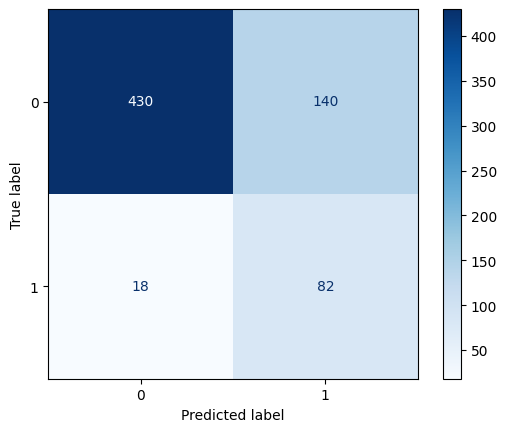

In [37]:
# Set threshold
threshold = 0.4
nn_y_pred = (nn_model.predict(X_test_scaled) > threshold).astype(int)

# Classification report
nn_report = classification_report(y_test, nn_y_pred)

print(f'\n{nn_report}')

nn_cm = confusion_matrix(y_test, nn_y_pred, labels=[0,1])
ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=[0,1]).plot(cmap='Blues')
plt.show()

### The Neural Network performed as well as SVM and XGBoost!

Unfortunately, neural networks are known to be "black box" models, making it difficult to access feature importances (more to do with the weights set by the model, but I am new to deep learning).

Looking at the algorithms we chose, logistic regression has the advantage of high interpretability at the cost of low flexibility, whereas the other models (bagging, boosting, neural networks, & SVM) are the opposite: low interpretability, but higher flexibility.

As our low interpretability models performed better, we must be aware that feature importances are correlation and not causation, and furthering testing is needed before a causal inference can be made.

21/21 [==============================] - 0s 777us/step


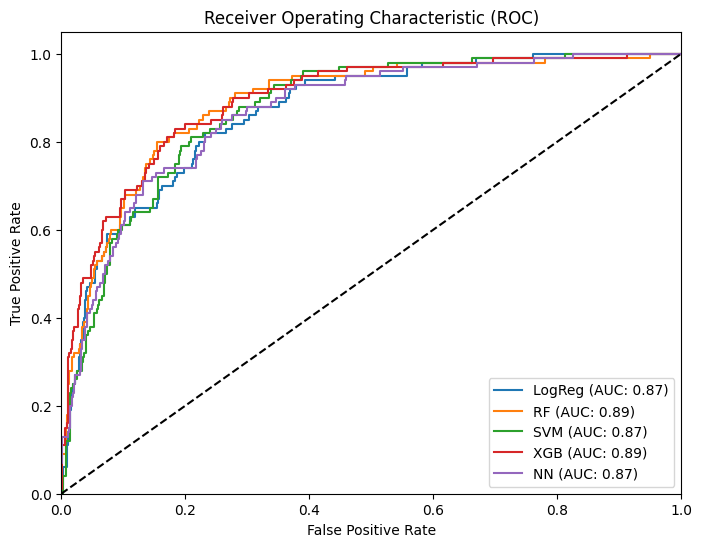

In [38]:
from sklearn.metrics import roc_curve, auc

def plot_multi_roc(models, model_names):
    """
    Plots ROC curves for multiple models.
    
    Parameters:
    - models: list of trained models
    - X_tests: list of test data for each model
    - y_test: true labels
    - model_names: list of model names for legend
    - is_neural_net: list of boolean values indicating if the model is a neural network
    
    Returns:
    - A plot with ROC curves for all models
    """
    
    plt.figure(figsize=(8, 6))
    
    # For each model, compute ROC curve and AUC
    for model, name in zip(models, model_names):
        if model == svm_best_clf:
            # For SVM
            probs = model.predict_proba(X_test_scaled)[:, 1]
        elif model == nn_model:
            # For Neural Network
            probs = model.predict(X_test_scaled).ravel()
        else:
            probs = model.predict_proba(X_test_encoded)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc:.2f})')
        
    # Plotting the random line
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    
    plt.show()

# Use plot_multi_roc() function
plot_multi_roc([best_logreg_clf, best_rf_clf, svm_best_clf, best_xgb_clf, nn_model],
               ['LogReg', 'RF', 'SVM', 'XGB', 'NN'])

Looking at our different models, we can see that their AUC scores are quite similar, meaning that the models distinguish between positive and negative classes in a similar manner, especially as our dataset was imbalanced (~85% class 0 to ~15% class 1).

Let's look at other metrics for business insights, given that our models have similar AUC scores.

# How do models compare with prediction costs?

The business problem is to correctly classify existing customers that are most likely to sign up for this offer. 

The deal will cost the company potentially \$500 (\$999-\$499) off regular membership, but the real cost to the company is unknown, as it depends on what a customer spends. Every membership gives future discount, but if a customer buys membership and makes no purchases, the company effectively makes \$499 (or \$999 full price).

When we look at how much people are spending, 20\% off for \$499 is terrible for the customer based on their spending habits from the dataset!

In [39]:
# If you pay $499 for membership for 20% discount, you need to spend $2495 to save $499, creating a breakeven point.
# How many people spent > $2495?

data_cleaned[data_cleaned['TotalSpent'] > 2495]

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalSpent,Year,Month,Day,Weekday
Dt_Customer,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-13,5735,1991,Master,Single,90638.0,0,0,29,1156,120,915,94,144,96,1,3,4,10,1,0,0,2525,2014,2,13,3
2014-02-13,5350,1991,Master,Single,90638.0,0,0,29,1156,120,915,94,144,96,1,3,4,10,1,1,0,2525,2014,2,13,3
2013-07-27,1763,1988,Bachelor,Married,87679.0,0,0,62,1259,172,815,97,148,33,1,7,11,10,4,1,0,2524,2013,7,27,5


### ONLY 3 PEOPLE SPENT MORE THAN $2495!

Let's look at the distribution of spending.

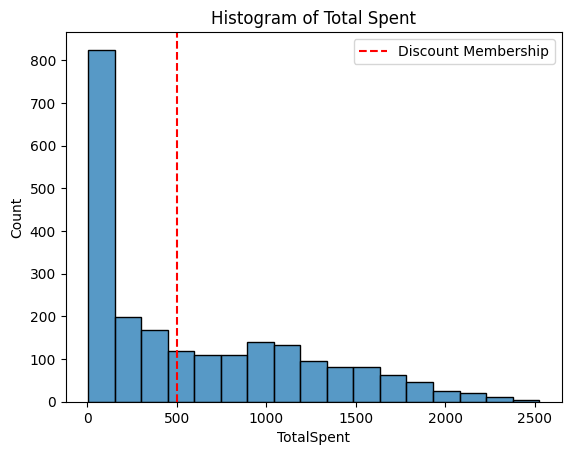

In [40]:
sns.histplot(data_cleaned['TotalSpent'])
plt.axvline(x=499, color='red', linestyle='--', label='Discount Membership')
plt.title('Histogram of Total Spent')
plt.legend()
plt.show()

In [41]:
# What % of people spent more than $499?
mask = data_cleaned['TotalSpent'] > 499

frac_over_499 = (len(data_cleaned[mask]) / len(data_cleaned)) * 100

print(f'Percentage of respondents that spent over $499: {frac_over_499:.2f}%')

Percentage of respondents that spent over $499: 44.47%


### But remember!

We are here to do a job whether we agree with it or not.

## Given the business problem, perhaps it may not be possible to offer the deal to everyone.

At first glance, it would make sense to maximize precision because it is costing \$500 to the company to give the deal (vs. full price) plus the 20\% off future purchases. But with the company making \$499 per customer, given that more than half the people in the dataset spent less than $499, perhaps improving recall is the best strategy.

However, there may be reasons why it is not feasible to market to everyone. As the predictive modelling focuses on **acquisition**, time and resources are still essential to **persuade** and **convert** potential customers.

For example, if a target customer profile is someone with high income, perhaps they may not want a membership if everyone gets one. In fact, charging a high price for membership may indicate prestige, creating new value to someone who may not be spending enough to make use of the 20% member discount.


## Hypothetical Cost Matrix

|         | Predicted DECLINE           | Predicted ACCEPT  |
| ------------- |------------| -----:|
| **Actual DECLINE**      | $0 | $50 |
| **Actual ACCEPT**   | $499 | $50 |

Let's assume that it costs $50 to try to persuade and convert a potential customer.

In [42]:
# Create Confusion Matrices & Convert to List
logreg_cm = confusion_matrix(y_test, best_logreg_predictions)
logreg_cm_list = [item for sublist in logreg_cm for item in sublist]

rf_cm = confusion_matrix(y_test, rf_predictions)
rf_cm_list = [item for sublist in rf_cm for item in sublist]

svm_cm = confusion_matrix(y_test, svm_best_predictions)
svm_cm_list = [item for sublist in svm_cm for item in sublist]

xgb_cm = confusion_matrix(y_test, best_xgb_predictions)
xgb_cm_list = [item for sublist in xgb_cm for item in sublist]

nn_cm_list = [item for sublist in nn_cm for item in sublist]

all_list_cm = [[0,570],[0,100]]
all_list = [item for sublist in all_list_cm for item in sublist]

# Create Hypothetical Cost Confusion Matrix
hypoth_cost = [0, 50, 499, 50]

# Calculate Costs
cost_logreg = [x * y for x, y in zip(hypoth_cost, logreg_cm_list)]
cost_rf = [x * y for x, y in zip(hypoth_cost, rf_cm_list)]
cost_svm = [x * y for x, y in zip(hypoth_cost, svm_cm_list)]
cost_xgb = [x * y for x, y in zip(hypoth_cost, xgb_cm_list)]
cost_nn = [x * y for x, y in zip(hypoth_cost, nn_cm_list)]
cost_all = [x * y for x, y in zip(hypoth_cost, all_list)]

# Create a dataframe based on cost_logreg, cost_rf, cost_svm, cost_xgb, cost_nn, and cost_all
costs = [cost_logreg, cost_rf, cost_svm, cost_xgb, cost_nn, cost_all]
df_costs = pd.DataFrame(costs)

df_costs['Model'] = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Neural Network', 'Campaign ALL']
df_costs.set_index('Model', inplace=True)

profit = 499
df_costs['Total Profit'] = [logreg_cm_list[3]*profit, rf_cm_list[3]*profit, svm_cm_list[3]*profit,
                            xgb_cm_list[3]*profit, nn_cm_list[3]*profit, all_list[3]*profit]

df_costs['Total Cost'] = [sum(cost_logreg), sum(cost_rf), sum(cost_svm), sum(cost_xgb), sum(cost_nn), sum(cost_all)]
df_costs.rename(columns={0: 'True Negative', 1: 'False Positive', 2: 'False Negative', 3: 'True Positive'}, inplace=True)

df_costs['Net'] = df_costs['Total Profit'] - df_costs['Total Cost']

df_costs

,True Negative,False Positive,False Negative,True Positive,Total Profit,Total Cost,Net
Model,,,,,,,
Logistic Regression,0,1100,29441,2050,20459,32591,-12132
Random Forest,0,600,33932,1600,15968,36132,-20164
SVM,0,7400,7984,4200,41916,19584,22332
XGBoost,0,750,30439,1950,19461,33139,-13678
Neural Network,0,7000,8982,4100,40918,20082,20836
Campaign ALL,0,28500,0,5000,49900,33500,16400


## At $50 conversion cost, SVM becomes the best model in maximizing net profit, followed by the Neural Network.

However, do changes in conversion cost determine which model we choose?

Let's see what that might look like.

In [43]:
net_changes = []

for i in range(0,101):
    hypoth_cost = [0, i, 499, i]
    cost_logreg = [x * y for x, y in zip(hypoth_cost, logreg_cm_list)]
    cost_rf = [x * y for x, y in zip(hypoth_cost, rf_cm_list)]
    cost_svm = [x * y for x, y in zip(hypoth_cost, svm_cm_list)]
    cost_xgb = [x * y for x, y in zip(hypoth_cost, xgb_cm_list)]
    cost_nn = [x * y for x, y in zip(hypoth_cost, nn_cm_list)]
    cost_all = [x * y for x, y in zip(hypoth_cost, all_list)]

    # Create a dataframe based on cost_logreg, cost_rf, cost_svm, cost_xgb, cost_nn, and cost_all
    costs = [cost_logreg, cost_rf, cost_svm, cost_xgb, cost_nn, cost_all]
    df_costs = pd.DataFrame(costs)

    df_costs['Model'] = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Neural Network', 'Campaign ALL']
    df_costs.set_index('Model', inplace=True)

    df_costs['Total Profit'] = [logreg_cm_list[3]*499, rf_cm_list[3]*499, svm_cm_list[3]*499,
                                xgb_cm_list[3]*499, nn_cm_list[3]*499, all_list[3]*499]

    df_costs['Total Cost'] = [sum(cost_logreg), sum(cost_rf), sum(cost_svm), sum(cost_xgb), sum(cost_nn), sum(cost_all)]
    df_costs.rename(columns={0: 'True Negative', 1: 'False Positive', 2: 'False Negative', 3: 'True Positive'}, inplace=True)

    df_costs['Net'] = df_costs['Total Profit'] - df_costs['Total Cost']
    
    net_changes.append(df_costs['Net'].tolist())

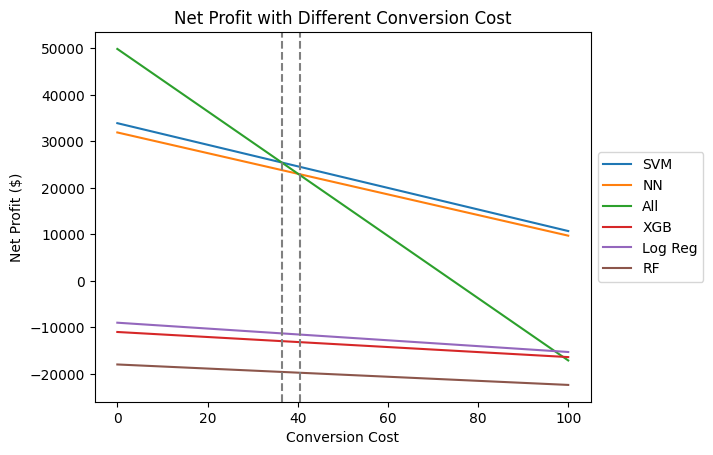

In [44]:
# Plot Changes
net_changes_df = pd.DataFrame(net_changes, columns=['Log Reg', 'RF', 'SVM', 'XGB', 'NN', 'All'])
net_changes_df['Conversion Cost'] = [num for num in range(0, 101)]

ax = net_changes_df.plot(x='Conversion Cost', y=['SVM', 'NN', 'All', 'XGB','Log Reg', 'RF'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Conversion Cost')
plt.ylabel('Net Profit ($)')
plt.title('Net Profit with Different Conversion Cost')

# Add vertical lines where All intersects with SVM and NN
plt.axvline(x=36.5, color='grey', linestyle='--')
plt.axvline(x=40.5, color='grey', linestyle='--')

plt.show()

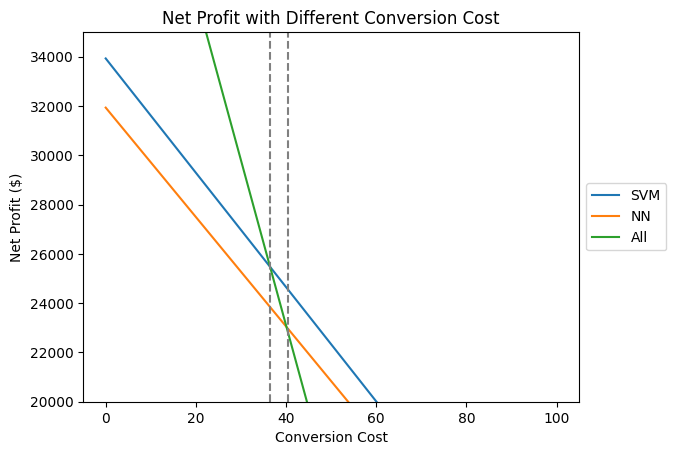

In [45]:
# ZOOM IN
ax = net_changes_df.plot(x='Conversion Cost', y=['SVM', 'NN', 'All'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Conversion Cost')
plt.ylabel('Net Profit ($)')
plt.title('Net Profit with Different Conversion Cost')
plt.ylim(20000, 35000)

# Add vertical lines where All intersects with SVM and NN
plt.axvline(x=36.5, color='grey', linestyle='--')
plt.axvline(x=40.5, color='grey', linestyle='--')

plt.show()

### Given our validation dataset, we have 100 people to convert to maximize our profit.

If it costs anything less that ~\$37.50 per person, it would be better to market to everyone. 

From ~\$37.50, SVM is the best model to use.

At some point, it looks like the Neural Network becomes the best model, but it looks very close to the breakeven point, which is not very useful.

# Customer Profiles through Clustering

## Clustering

Here we may find similar clusters of people to target specifically. Particularly, we want to find clusters with the highest proportion of accepting the offer, and contrast them from groups with the lowest acceptance to look for additional insights.

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

X_cluster = data_cleaned.copy()
X_cluster.drop(columns=['Id', 'Year'])
X_cluster['Income'] = imputer.fit_transform(X_cluster[['Income']])
X_cluster_encoded = pd.get_dummies(X_cluster)

# Scale the data for k-means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster_encoded)

num_clusters = [i for i in range(2, 21)]

In [47]:
# Perform clustering on scaled data and calculate metrics via function
def calculate_cluster_metrics(num_clusters, x_vals):
    inertia = []
    silhouette_vals = []
    ch_vals = []
    
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=1)
        labels = kms.fit_predict(x_vals)
        
        inertia.append(kms.inertia_)
        silhouette_vals.append(silhouette_score(x_vals, labels))
        ch_vals.append(calinski_harabasz_score(x_vals, labels))
    
    return [inertia, silhouette_vals, ch_vals]

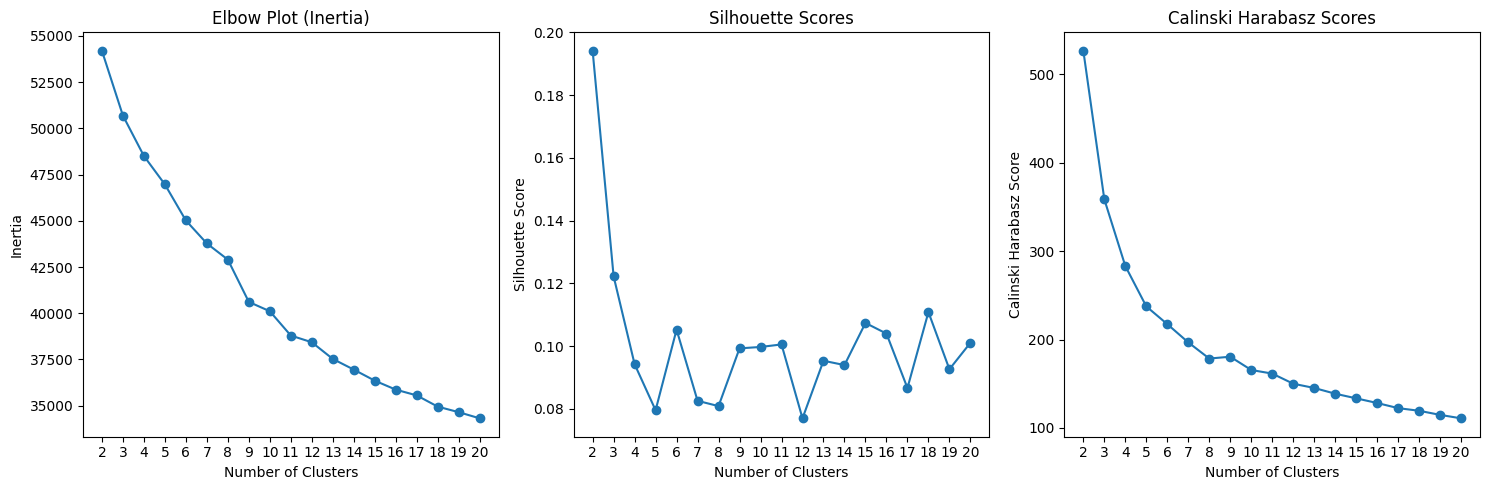

In [48]:
# Calculate metrics
cluster_metrics = calculate_cluster_metrics(num_clusters, X_scaled)

# Plot
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(num_clusters, cluster_metrics[0], '-o')
plt.title('Elbow Plot (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(num_clusters)

plt.subplot(1, 3, 2)
plt.plot(num_clusters, cluster_metrics[1], '-o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters)

plt.subplot(1, 3, 3)
plt.plot(num_clusters, cluster_metrics[2], '-o')
plt.title('Calinski Harabasz Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.xticks(num_clusters)

plt.tight_layout()
plt.show()

## That really isn't helpful

As we do have a lot of features, this is expected (i.e. the curse of dimensionality). There is no distinct hinge or elbow for inertia, making it hard to determine an optimal number of clusters. Calinski-Harabasz scores are low, which also indicates poor clustering.

There is a slight improvement in silhouette score (how similar something is to its cluster compared to another) at 18 clusters, so we will explore that.

In [49]:
# We will choose 18 clusters, based on silhouette score, but really it could be anything...
k_optimal = 18
kmeans = KMeans(n_clusters=k_optimal, random_state=1)
kmeans.fit(X_scaled)

# Transform back to original scale
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(np.round(cluster_centers_original,4), columns=X_cluster_encoded.columns)

cluster_centers_df

,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalSpent,Year,Month,Day,Weekday,Education_Bachelor,Education_High School,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single
0,5618.3874,1964.0090,58309.6757,0.1171,0.9279,46.3514,446.7928,22.4505,148.3063,31.7297,28.1351,68.8559,3.2793,6.5856,3.3153,7.4685,5.7568,0.0541,0.0,746.2703,2012.8559,6.7748,14.7207,3.3423,0.7748,0.0,0.2252,0.0000,-0.0000,1.0000
1,5546.0235,1971.5915,37619.0563,0.6338,0.5211,49.1080,65.0751,5.8685,29.4507,9.0282,6.3850,20.1408,2.1127,2.5023,0.7700,3.6009,6.0047,0.0704,0.0,135.9484,2013.1502,6.2207,14.7136,3.1268,0.0000,0.0,1.0000,-0.0000,1.0000,0.0000
2,5951.3419,1969.5419,75485.6000,0.0516,0.1935,51.1226,535.9806,82.0645,443.7484,127.0129,88.3806,87.3613,1.2903,5.2774,5.7419,8.6903,2.7226,0.0452,0.0,1364.5484,2013.0645,6.3935,16.1484,3.2258,0.9548,0.0,0.0387,0.0065,1.0000,0.0000
3,5609.0949,1971.8513,33877.3259,0.8006,0.4399,50.0759,39.0095,4.6139,23.0791,8.9494,5.0316,15.4557,1.9589,2.1171,0.5095,3.2468,6.5190,0.0601,0.0,96.1392,2013.1266,6.1899,16.3449,2.9589,1.0000,0.0,-0.0000,-0.0000,1.0000,0.0000
4,5298.5421,1968.5981,71458.8692,0.0374,0.2523,62.0467,455.9907,80.7570,392.8598,116.0000,68.2150,93.4112,1.3738,4.6262,5.4766,8.9720,2.6542,0.0093,0.0,1207.2336,2013.1028,6.7477,14.2150,3.3458,0.7477,0.0,0.1869,0.0654,-0.0000,1.0000
5,5681.0476,1970.6746,80641.0476,0.0397,0.0476,40.2857,769.5238,68.5873,587.4365,95.8730,70.9762,80.0952,1.0556,5.2857,6.3095,7.8254,2.9683,0.9603,0.0,1672.4921,2012.9048,6.6032,14.6667,2.7063,0.5873,0.0,0.2778,0.1349,0.3095,0.6905
6,5323.6722,1972.7556,35391.8444,0.7778,0.4000,51.8778,38.9222,6.0389,25.6444,7.7556,6.2222,15.4389,2.0056,2.1667,0.5722,3.1611,6.4556,0.1056,0.0,100.0222,2013.0944,6.6111,15.4500,3.0611,1.0000,0.0,-0.0000,-0.0000,-0.0000,1.0000
7,5681.3360,1963.6320,70202.7680,0.0800,0.4720,44.7920,533.6000,51.3760,267.9120,72.9520,52.6400,60.7920,1.9280,5.4720,4.8400,8.9360,3.6080,0.0640,0.0,1039.2720,2013.0800,5.7040,15.6240,3.1360,0.0000,0.0,1.0000,-0.0000,0.9200,0.0800
8,5808.7614,1968.3636,78439.0341,0.0341,0.1364,54.7955,787.9659,44.6136,540.2045,63.0795,46.7500,47.6477,1.5227,5.0114,7.3864,7.5227,2.7500,0.2045,0.0,1530.2614,2012.9545,6.7273,16.3977,2.9773,0.0341,0.0,0.0114,0.9545,0.8864,0.1136
9,5396.4074,1977.4630,20306.2593,0.6296,0.0926,48.4444,7.2407,11.1111,11.4444,17.0556,12.1111,22.8333,1.7963,1.8889,0.4815,2.8519,6.8704,0.0370,0.0,81.7963,2012.7778,6.6667,17.5000,2.7963,0.0000,1.0,0.0000,0.0000,0.6296,0.3704


In [50]:
# Predict the clusters for the scaled data
clusters = kmeans.predict(X_scaled)

# Add the cluster predictions as a new column to the dance dataset
df_cluster = X_cluster_encoded.copy()

df_cluster['cluster'] = clusters

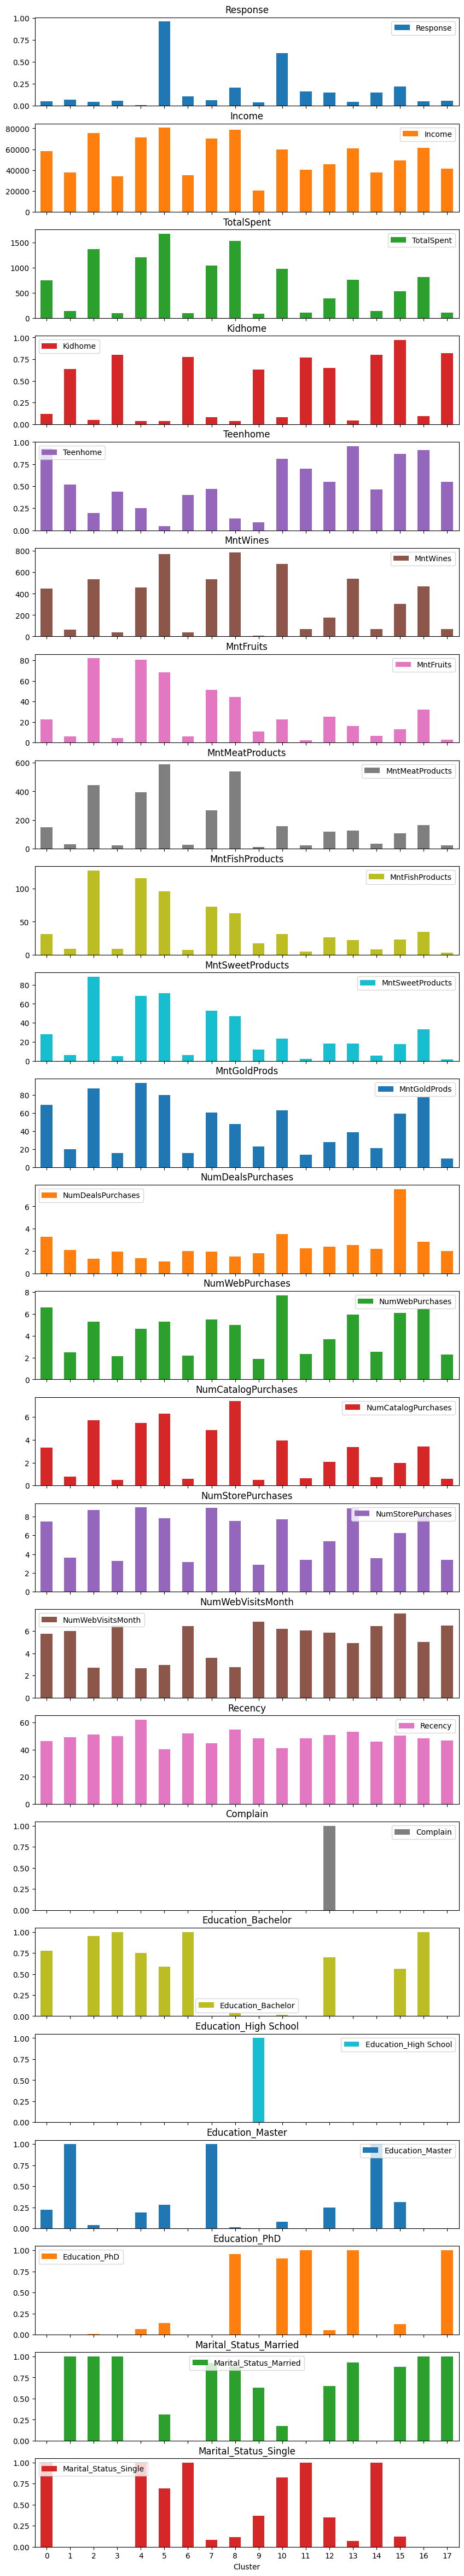

In [51]:
# Plot key features for each cluster
cluster_centers_df[[
    'Response',
    'Income', 'TotalSpent',
    'Kidhome', 'Teenhome',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
    'Recency', 'Complain',
    'Education_Bachelor', 'Education_High School', 'Education_Master', 'Education_PhD',
    'Marital_Status_Married', 'Marital_Status_Single'
]].plot(subplots=True, kind='bar', figsize=(10,60))
plt.xticks(range(len(cluster_centers_df)), range(len(cluster_centers_df)))
plt.xticks(rotation=0)
plt.xlabel('Cluster')
plt.legend(loc='upper left')
plt.show()

In [52]:
# Most responses = Cluster '5'
most_response_df = df_cluster[df_cluster['cluster'] == 5]
most_response_mean = most_response_df.describe().loc['mean']

# Least responses = Cluster '4'
least_response_df = df_cluster[df_cluster['cluster'] == 4]
least_response_mean = least_response_df.describe().loc['mean']

# Combine most_response_mean and least_response_mean
combined_mean = pd.concat([most_response_mean, least_response_mean], axis=1)
combined_mean.columns = ['Most Response', 'Least Response']
combined_mean = combined_mean.T

combined_mean.reset_index(inplace=True)
combined_mean

,index,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,TotalSpent,Year,Month,Day,Weekday,Education_Bachelor,Education_High School,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,cluster
0,Most Response,5681.047619,1970.674603,80641.047619,0.039683,0.047619,40.285714,769.523810,68.587302,587.436508,95.873016,70.976190,80.095238,1.055556,5.285714,6.309524,7.825397,2.968254,0.960317,0.0,1672.492063,2012.904762,6.603175,14.666667,2.706349,0.587302,0.0,0.277778,0.134921,0.309524,0.690476,5.0
1,Least Response,5298.542056,1968.598131,71458.869159,0.037383,0.252336,62.046729,455.990654,80.757009,392.859813,116.000000,68.214953,93.411215,1.373832,4.626168,5.476636,8.971963,2.654206,0.009346,0.0,1207.233645,2013.102804,6.747664,14.214953,3.345794,0.747664,0.0,0.186916,0.065421,0.000000,1.000000,4.0


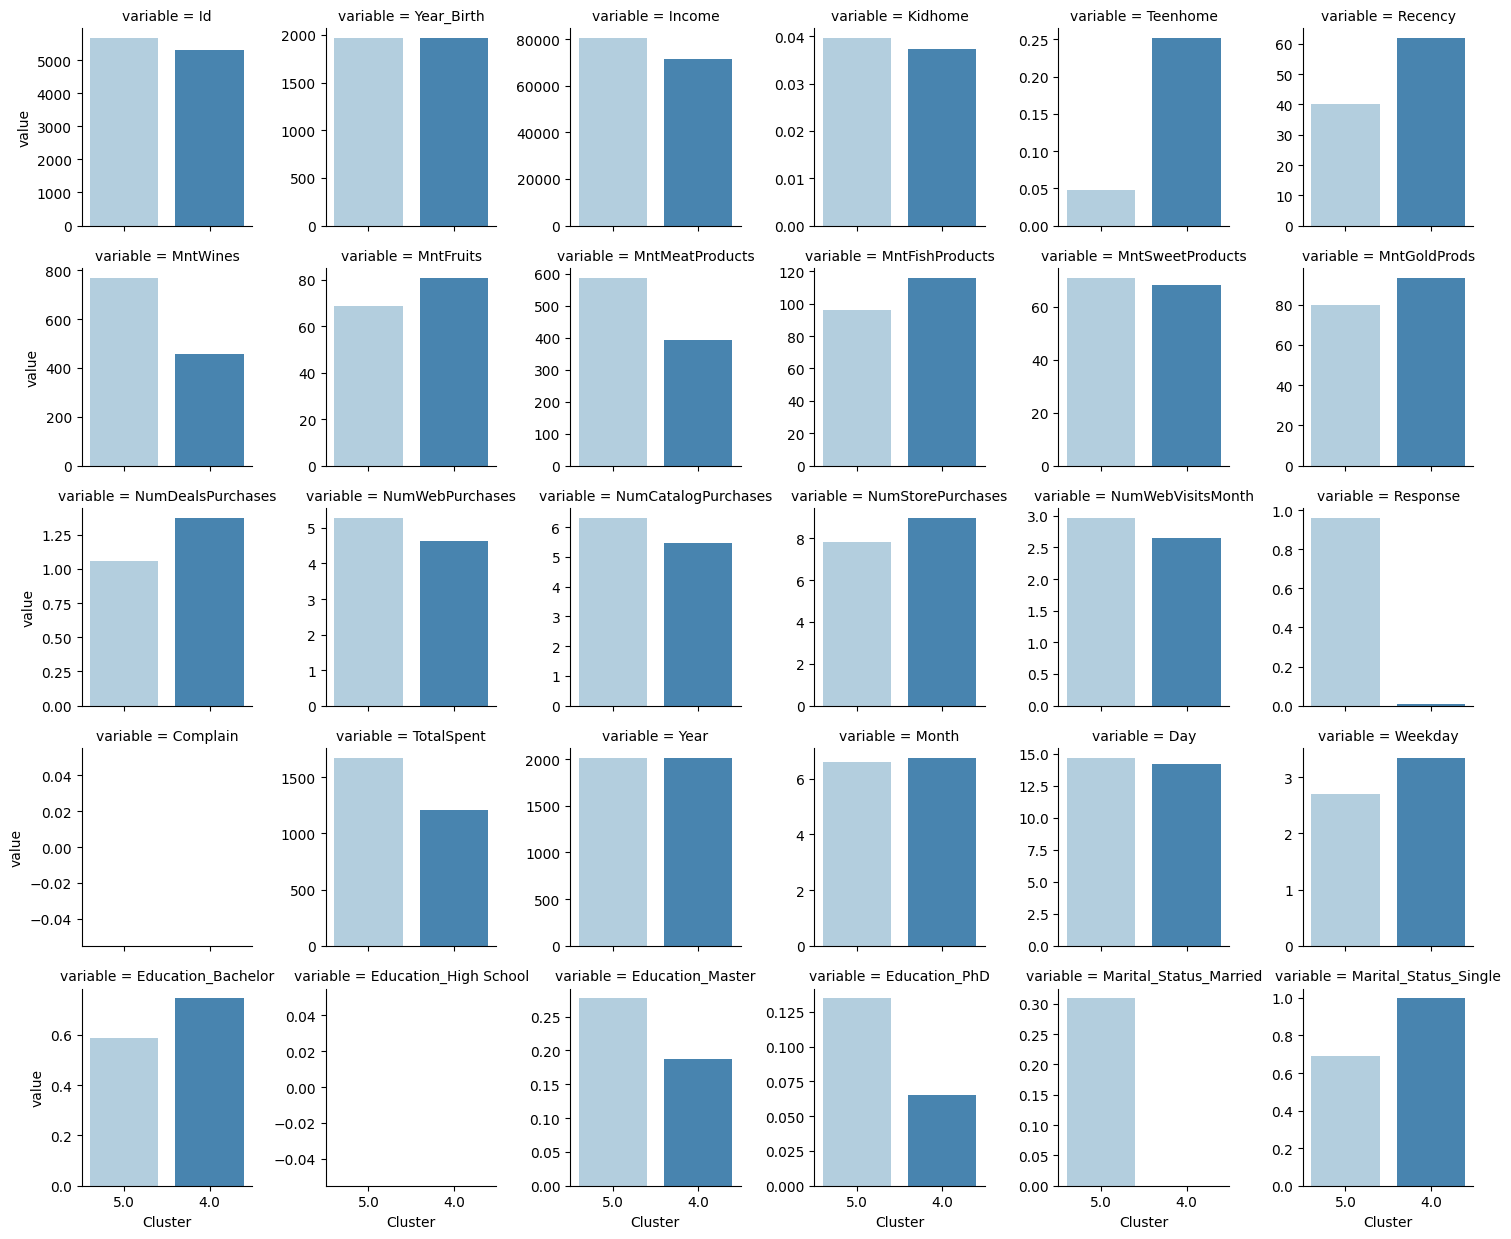

In [53]:
combined_melted = combined_mean.melt(id_vars='index', value_vars=cluster_centers_df.columns)

# Create a facet grid
grid = sns.FacetGrid(combined_melted, col="variable", col_wrap=6, height=2.5, sharey=False)

# Map the barplot onto the grid
grid.map(sns.barplot, 'index', 'value', order=combined_mean['index'].unique(), palette='Blues')

# Adjust x-axis labels
for ax in grid.axes.flat:
    ax.set_xticklabels(combined_mean['cluster'])

# Set x-axis label
grid.set_xlabels('Cluster')

# Show the plot
plt.show()

## Cluster Analysis

### Cluster 5 (most responsive) has:
- Slightly more `Income`
- Spends more on `MntWines` and `MntMeatProducts`
- Has more `NumWebPurchases`, `NumCatalogPurchases`, and `NumWebVisitsMonth`
- Spends more overall (`TotalSpent`)
- Has higher education (`Education_Master` or `Education_PhD`)
- Married! (`Marital_Status_Married`)

**Profile:** Married, possibly with a young kid (pre-teen), highly educated, and making good money. Probably spending money on membership for prestige.

### Cluster 4 (least responsive) has:
- Teenagers (`Teenhome`)
- Greater `Recency` since last purchase
- Buys slightly more `MntFruits`, `MntFishProducts`, `MntGoldProds`
- More `NumDealsPurchases` & `NumStorePurchases`
- Has `Education_Bachelor`
- More likely to be `Marital_Status_Single`

**Profile:** Single parent with kids and/or teens. Fairly well educated and decent income. Smart enough to avoid paying for a membership where they aren't spending enough to get value from. Or maybe saving up for their teen to go to college.

# Final Recommendations

### Consider the SVM predictive model
- This model has a high recall score and is the most cost effective if cost of a customer is greater than ~$37.50.
- If cost to get a customer is less than $37.50, it is cheaper to target everyone.

### Target the customers with a profile similar to Cluster 5
- Look to those who spend more on wine and meat products, has higher education, and is married
- Considering that they have a high amount of web purchases and web visits per month, perhaps an email campaign may be better than by phone.

### Target customers based on model feature importances
- Focus more on those who purchase more meat, wine, and gold products.
- Focus more on those with higher education levels (likely correlation with higher income).
- Focus less on those with teens at home.

### Other insights
- Date a member signed up is not very important
- Complaints are not very important!
- The membership deal is ridiculous, as very few people are saving more than the price of discounted membership.